## Object Segmentation

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-11-10 08:05:20--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-11-10 08:05:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-11-10 08:05:21--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
import pathlib

input_dir = pathlib.Path("images")
target_dir = pathlib.Path("annotations/trimaps")

input_img_paths = sorted(input_dir.glob("*.jpg"))
# Ignores some spurious files in the trimaps directory that start with a "."
target_paths = sorted(target_dir.glob("[!.]*.png"))

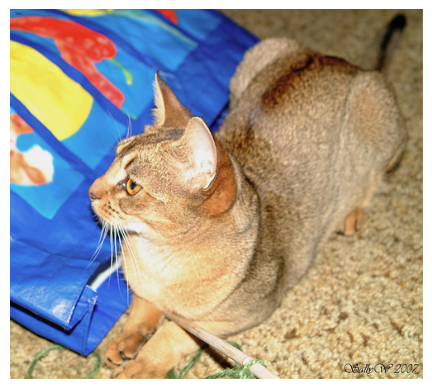

In [ ]:
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img

plt.axis("off")
# Displays input image number 9
plt.imshow(load_img(input_img_paths[9]))

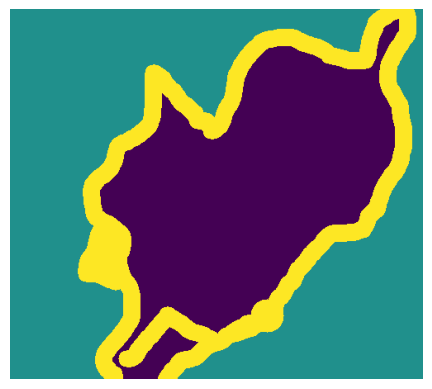

In [ ]:
def display_target(target_array):
    # 1 (foreground), 2 (background), 3 (contour)
    # The original labels are 1, 2, and 3. We subtract 1 so that the
    # labels range from 0 to 2, and then we multiply by 127 so that the
    # labels become 0 (black), 127 (gray), 254 (near-white).
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

# We use color_mode='grayscale' so that the image we load is treated as
# having a single color channel.
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

# We resize everything to 200 x 200 for this example.
img_size = (200, 200)
# Total number of samples in the data
num_imgs = len(input_img_paths)

# Shuffles the file paths (they were originally sorted by breed). We
# use the same seed (1337) in both statements to ensure that the input
# paths and target paths stay in the same order.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale")
    )
    # Subtracts 1 so that our labels become 0, 1, and 2
    img = img.astype("uint8") - 1
    return img

# Loads all images in the input_imgs float32 array and their masks in
# the targets uint8 array (same order). The inputs have three channels
# (RGB values), and the targets have a single channel (which contains
# integer labels).
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [ ]:
# Reserves 1,000 samples for validation
num_val_samples = 1000
# Splits the data into a training and a validation set
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=img_size + (3,)),
    # To rescale input images to the [0–1] range.
    tf.keras.layers.Rescaling(1./255),
    #  The purpose of this first half is to encode the images into smaller feature maps, where each
    #  spatial location (or “pixel”) contains information about a large spatial chunk of the original image.
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding="same"), # 1st conv layer
    #   we downsample by adding strides to every other convolution layer (No MaxPooling)
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"), # 2nd conv layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding="same"), # 3rd conv layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"), # 4th conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, activation='relu', padding="same"), # 5th conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"), # 6th conv layer

    #  Upsampling
    tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='relu', padding="same"),
    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding="same"),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding="same"),
    # We end the model with a per-pixel three-way softmax to classify
    # each output pixel into one of our three categories.
    tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation="softmax", padding="same")
    ])


foreground_iou = tf.keras.metrics.IoU(
    # Specifies the total number of classes
    num_classes=3,
    # Specifies the class to compute IoU for (0 = foreground)
    target_class_ids=(0,),
    name="foreground_iou",
    # Our targets are sparse (integer class IDs).
    sparse_y_true=True,
    # But our model's predictions are a dense softmax!
    sparse_y_pred=False,
)


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[foreground_iou],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

![](https://media.geeksforgeeks.org/wp-content/uploads/20230110162532/Transposed-Convolutional-2.png)
Transposed Convolutional  with stride 2
[Source](https://www.geeksforgeeks.org/machine-learning/what-is-transposed-convolutional-layer/)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "oxford_segmentation.keras",
        save_best_only=True,
    ),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                  min_delta=0.0001,
    #                                  patience=10,verbose=1,
    #                                  restore_best_weights=True),
]
history = model.fit(
    train_input_imgs,
    train_targets,
    epochs=30,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets),
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - foreground_iou: 0.9035 - loss: 0.1360 - val_foreground_iou: 0.7423 - val_loss: 0.5328
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - foreground_iou: 0.9202 - loss: 0.1153 - val_foreground_iou: 0.7451 - val_loss: 0.5745
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - foreground_iou: 0.9275 - loss: 0.1054 - val_foreground_iou: 0.7436 - val_loss: 0.5822
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - foreground_iou: 0.9305 - loss: 0.1001 - val_foreground_iou: 0.7415 - val_loss: 0.5797
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - foreground_iou: 0.9292 - loss: 0.1022 - val_foreground_iou: 0.7412 - val_loss: 0.6310
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - foreground_iou: 0.9347 - loss: 0.0946 - val_foreground_iou: 0.7396 - val_loss: 0.6655
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - foreground_iou: 0.9388 - loss: 0.0880 - val_foreground_iou: 0.7349 - val_loss: 0.6777

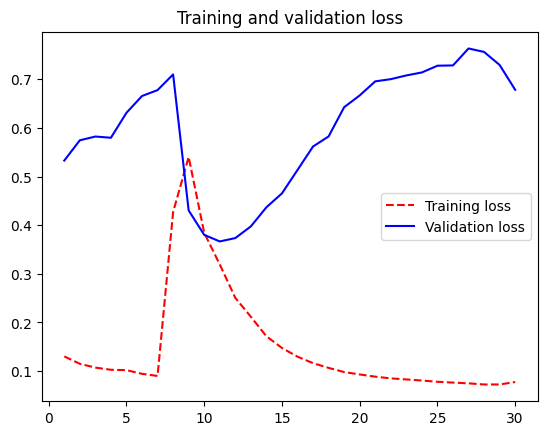

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


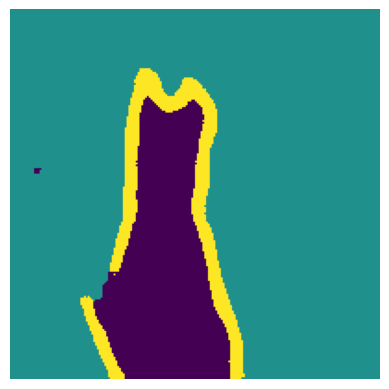

In [ ]:
model = tf.keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

# Utility to display a model's prediction
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

# Using a pretrained segmentation model
## Segment Anything Model

In [ ]:
import keras_hub

model = keras_hub.models.ImageSegmenter.from_preset("sam_huge_sa1b")
model.count_params()

641090864

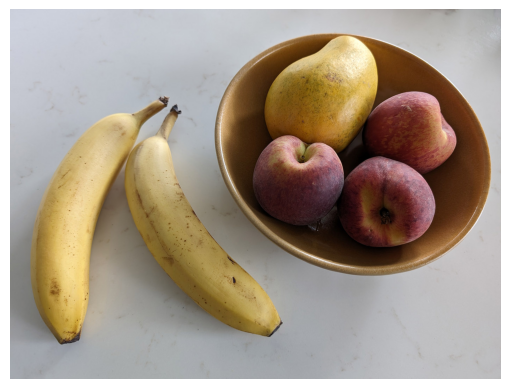

In [ ]:
# Downloads the image and returns the local file path
path = tf.keras.utils.get_file(
    origin="https://s3.amazonaws.com/keras.io/img/book/fruits.jpg"
)
# Loads the image as a Python Imaging Library (PIL) object
pil_image = tf.keras.utils.load_img(path)
# Turns the PIL object into a NumPy matrix
image_array = tf.keras.utils.img_to_array(pil_image)

# Displays the NumPy matrix
plt.imshow(image_array.astype("uint8"))
plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras import ops

image_size = (1024, 1024)

def resize_and_pad(x):
    return ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

image = resize_and_pad(image_array)

In [ ]:
# Helping functions
def show_image(image, ax):
    ax.imshow(ops.convert_to_numpy(image).astype("uint8"))

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w, _ = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(points, ax):
    x, y = points[:, 0], points[:, 1]
    ax.scatter(x, y, c="green", marker="*", s=375, ec="white", lw=1.25)

def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, ec="red", fc="none", lw=2))

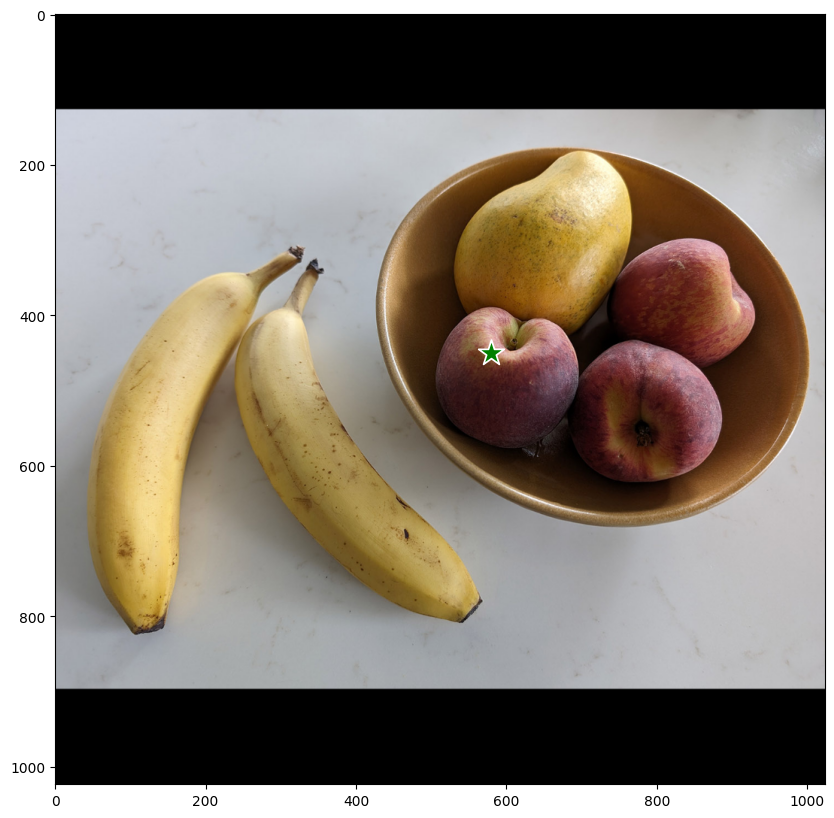

In [ ]:

# Coordinates of our point
input_point = np.array([[580, 450]])
# 1 means foreground, and 0 means background.
input_label = np.array([1])

plt.figure(figsize=(10, 10))
# "gca" means "get current axis" — the current figure.
show_image(image, plt.gca())
show_points(input_point, plt.gca())
plt.show()

In [ ]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step


In [ ]:
outputs["masks"].shape

(1, 4, 256, 256)

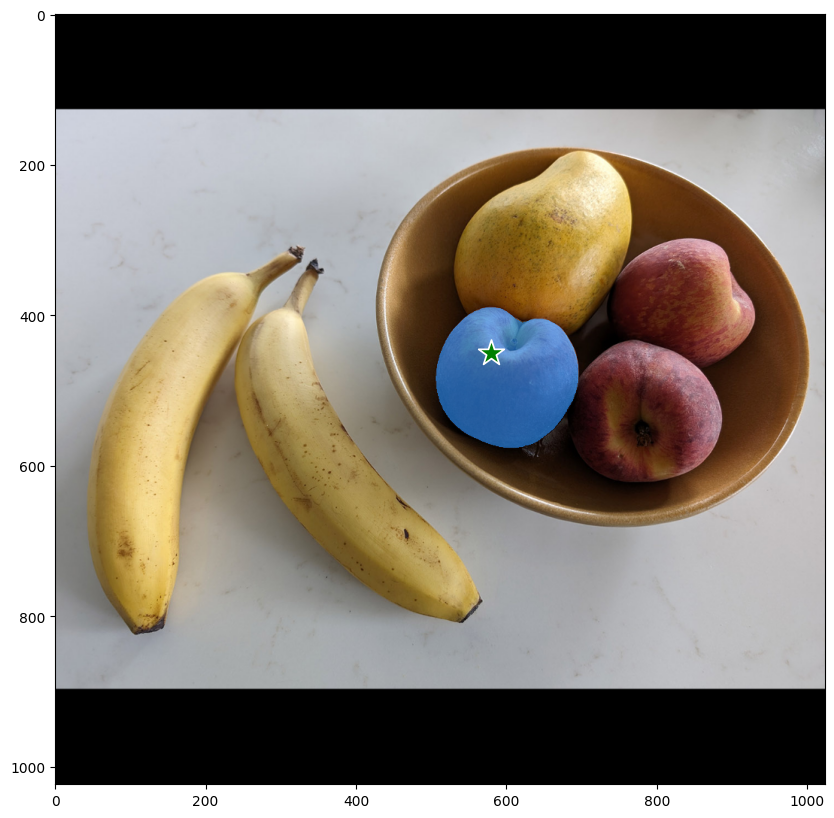

In [ ]:
def get_mask(sam_outputs, index=0):
    mask = sam_outputs["masks"][0][index]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize_and_pad(mask)
    return ops.convert_to_numpy(mask) > 0.0

mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


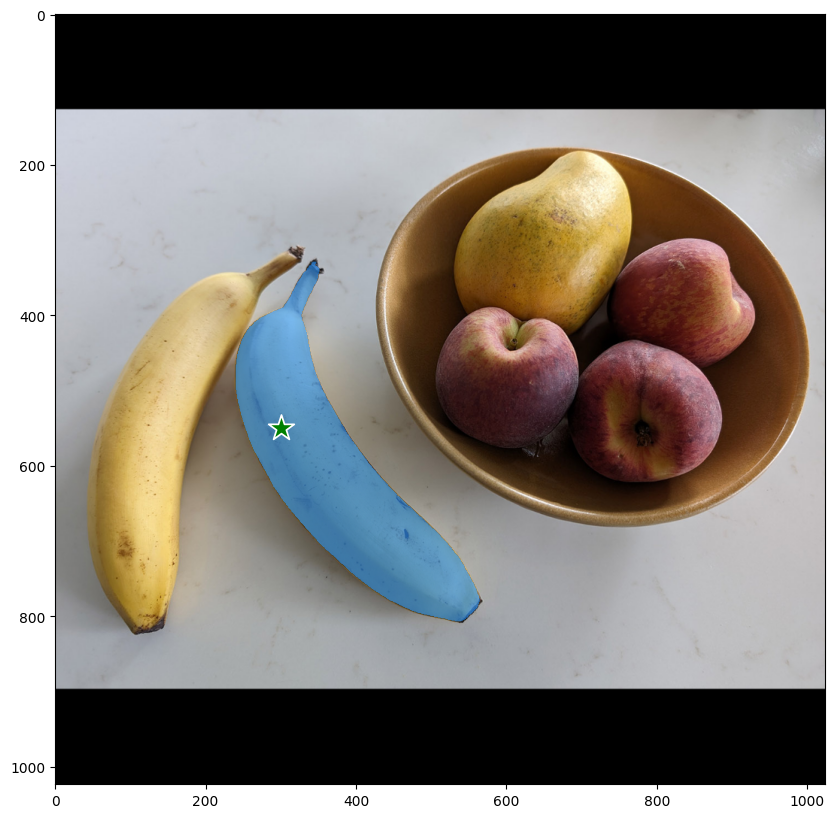

In [ ]:
input_point = np.array([[300, 550]])
input_label = np.array([1])

outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)
mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

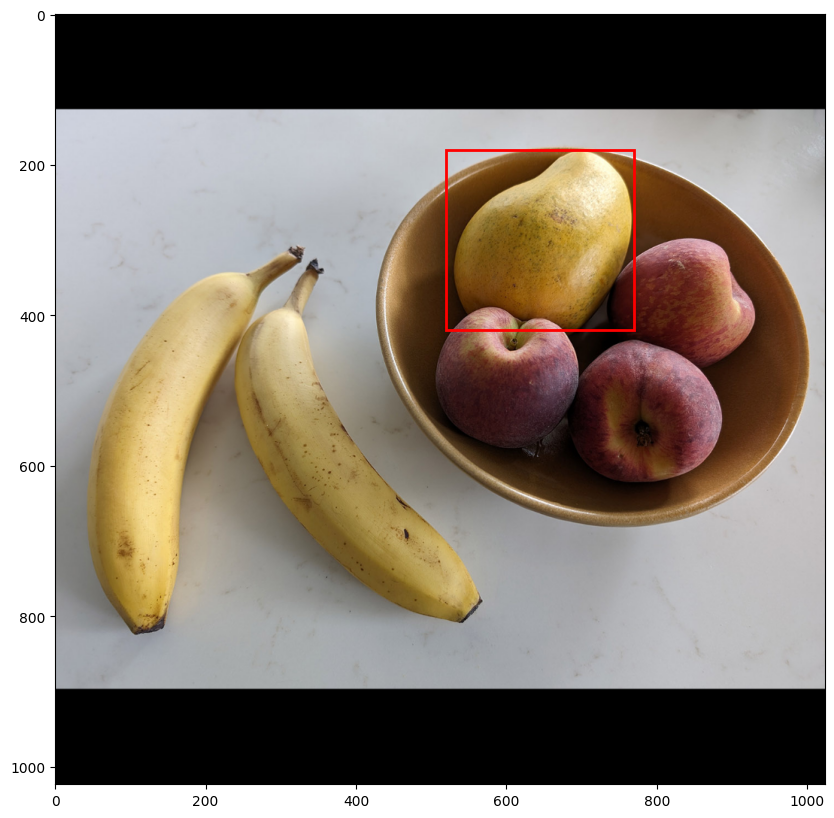

In [ ]:
input_box = np.array(
    [
        # Top-left corner
        [520, 180],
        # Bottom-right corner
        [770, 420],
    ]
)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_box(input_box, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step


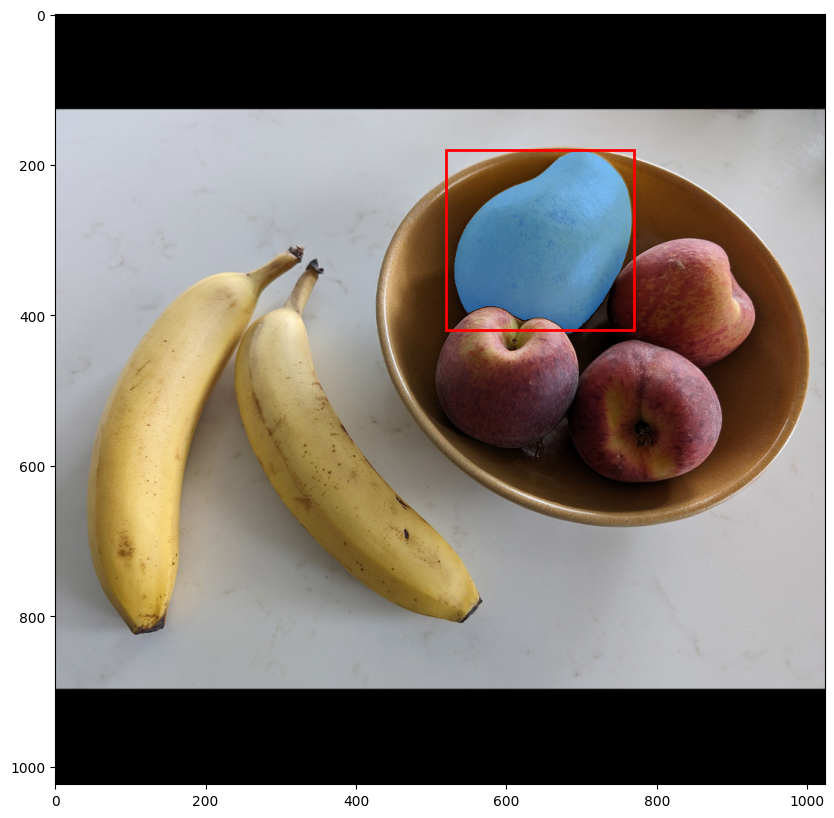

In [ ]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "boxes": ops.expand_dims(input_box, axis=(0, 1)),
    }
)
mask = get_mask(outputs, 0)
plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.show()

## Object Detection

In [ ]:
import keras_hub

url = "https://s3.us-east-1.amazonaws.com/book.keras.io/3e/seurat.jpg"

path = tf.keras.utils.get_file(origin=url)
image = np.array([tf.keras.utils.load_img(path)])

retinanet_detector = keras_hub.models.ObjectDetector.from_preset(
    "retinanet_resnet50_fpn_v2_coco",
    bounding_box_format="rel_xywh",
)
predictions = retinanet_detector.predict(image)

539653/539653 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 1.59k/1.59k [00:00<00:00, 3.36MB/s]


100%|██████████| 8.54k/8.54k [00:00<00:00, 13.7MB/s]


100%|██████████| 146M/146M [00:03<00:00, 41.9MB/s]


100%|██████████| 121M/121M [00:02<00:00, 50.2MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


In [ ]:
predictions

{'boxes': array([[[ 0.02755135,  0.6064345 ,  0.2810492 ,  0.16599132],
         [ 0.28917617,  0.5238688 ,  0.09747658,  0.18230583],
         [ 0.73489285,  0.25407636,  0.2139383 ,  0.5243618 ],
         [ 0.62694424,  0.45690748,  0.06340347,  0.12544036],
         [ 0.43246666,  0.4307505 ,  0.04761391,  0.12191681],
         [ 0.3785376 ,  0.5961819 ,  0.14924873,  0.13792633],
         [ 0.33820876,  0.30947098,  0.04144119,  0.13845   ],
         [ 0.43779662,  0.26162574,  0.1136877 ,  0.04007219],
         [ 0.5273677 ,  0.41609028,  0.10620476,  0.03688431],
         [ 0.3680033 ,  0.37952015,  0.03503372,  0.06919418],
         [ 0.2727511 ,  0.40732956,  0.08063528,  0.03161674],
         [-0.00125   , -0.00125   ,  0.        ,  0.        ],
         [-0.00125   , -0.00125   ,  0.        ,  0.        ],
         [-0.00125   , -0.00125   ,  0.        ,  0.        ],
         [-0.00125   , -0.00125   ,  0.        ,  0.        ],
         [-0.00125   , -0.00125   ,  0.       

In [ ]:
predictions["boxes"][0][0]

array([0.02755135, 0.6064345 , 0.2810492 , 0.16599132], dtype=float32)

---
## ℹ️
We have four different model outputs: bounding boxes, confidences, labels, and the total number of detections. The model can predict a total of 100 objects for each input model.

In [ ]:
[(k, v.shape) for k, v in predictions.items()]

[('boxes', (1, 100, 4)),
 ('confidence', (1, 100)),
 ('labels', (1, 100)),
 ('num_detections', (1,))]

In [ ]:
### Helper Functions ###

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    # Uses the golden ratio to generate new hues of a bright color with
    # the HSV colorspace
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_image(ax, image):
    # Draws the image on a unit cube with (0, 0) at the top left
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    # Pads the image so it fits inside the unit cube
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)


def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x, y, text, c="white", size=10, va="bottom", bbox=textbox)

def draw_final_image(path, predictions):
  fig, ax = plt.subplots(dpi=300)
  draw_image(ax, path)
  num_detections = predictions["num_detections"][0]
  for i in range(num_detections):
      box = predictions["boxes"][0][i]
      label = predictions["labels"][0][i]
      label_name = keras_hub.utils.coco_id_to_name(label)
      draw_box(ax, box, label_name, label_to_color(label))
  plt.show()



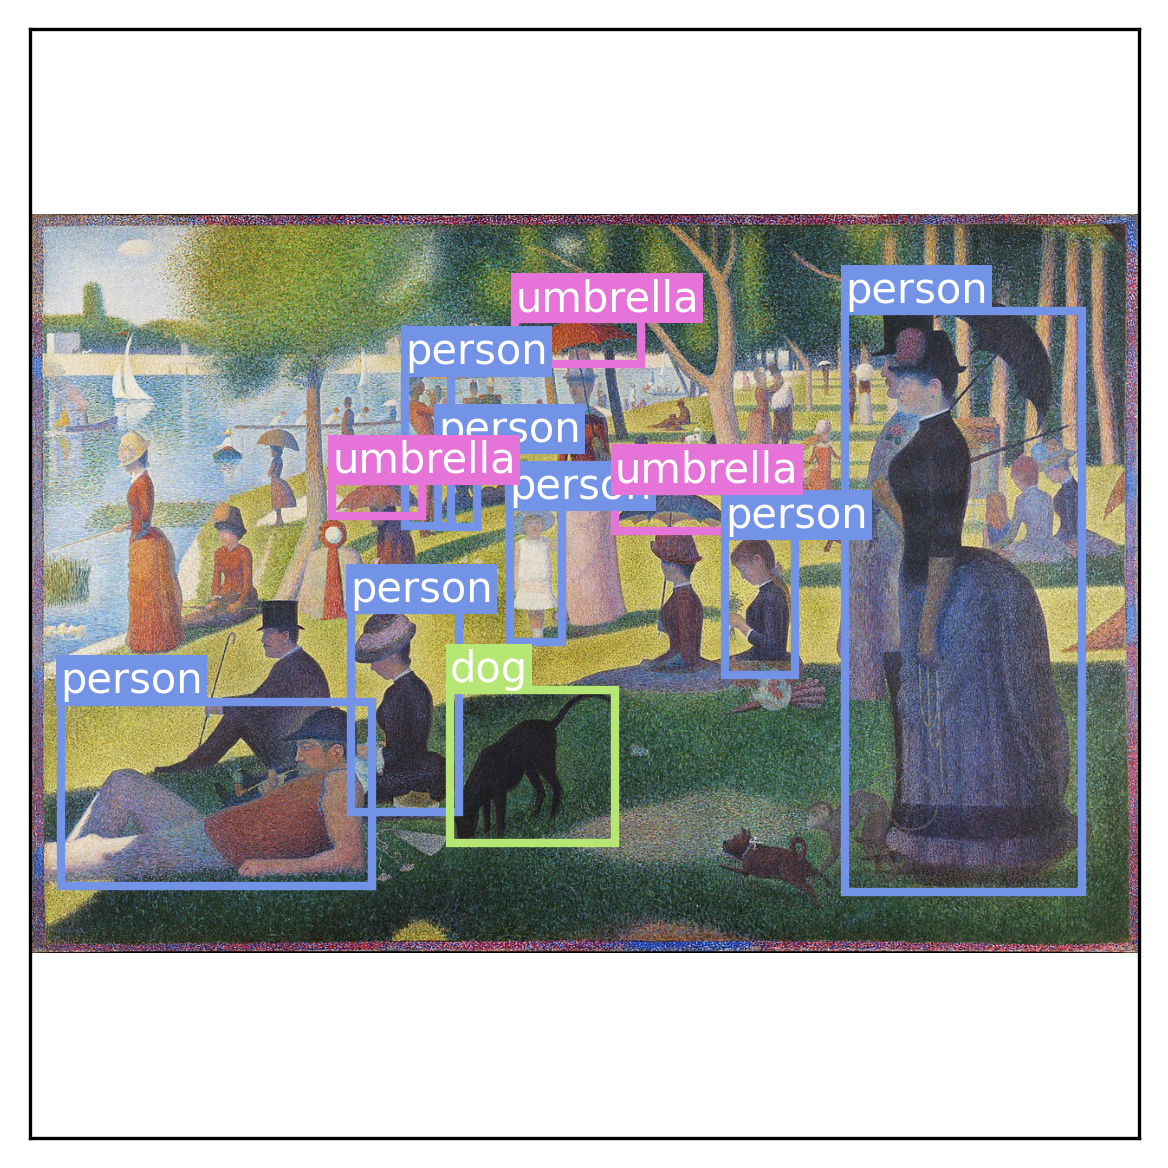

In [ ]:
draw_final_image(path, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


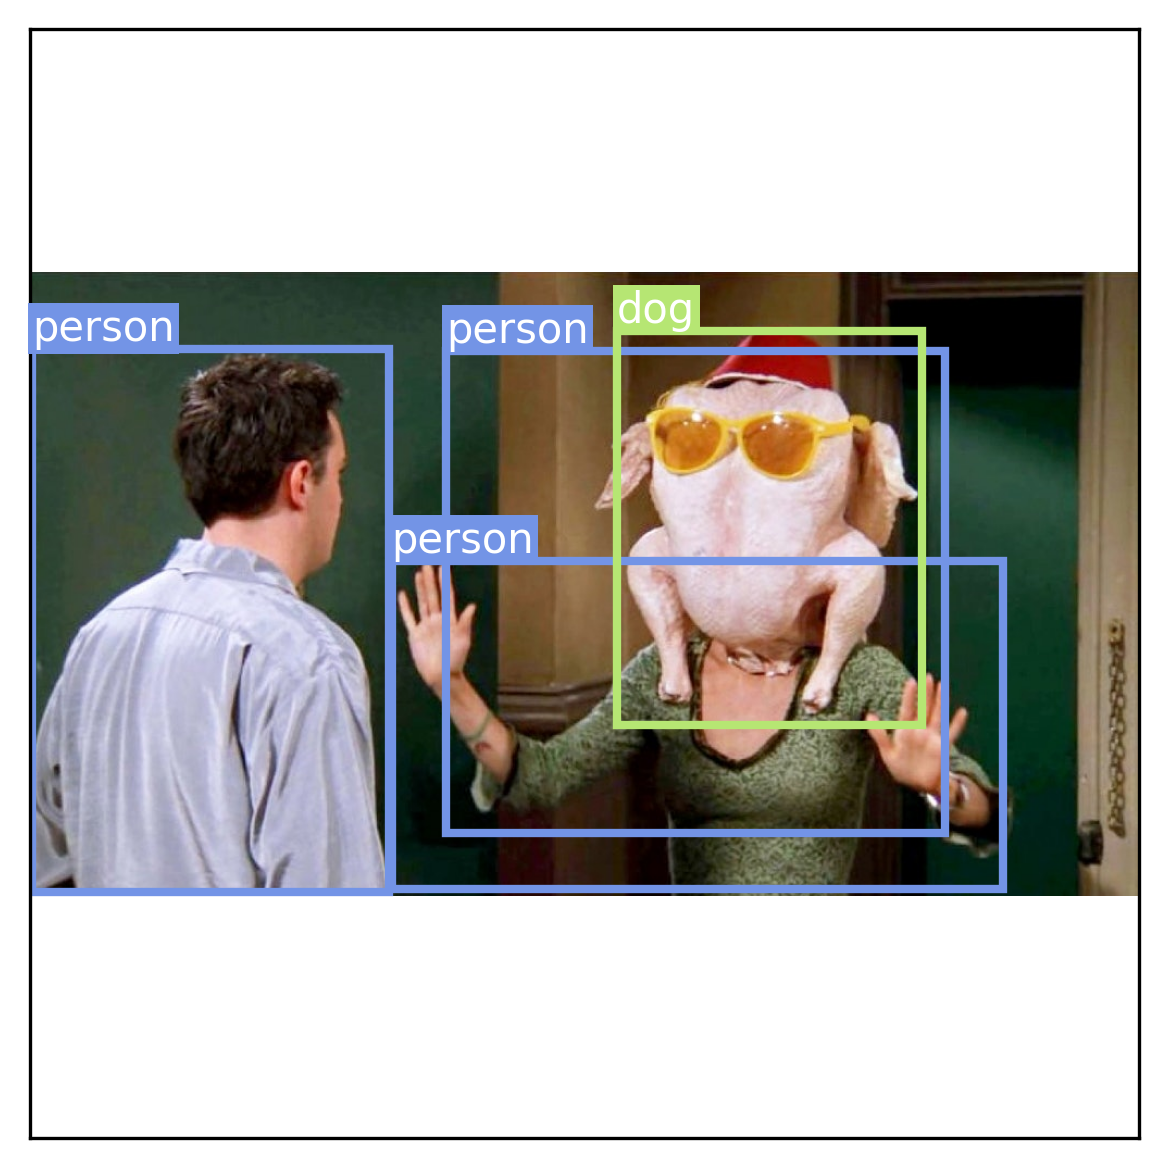

In [ ]:
# Example 2

path_2 = "test.jpg"
image_2 = np.array([tf.keras.utils.load_img(path_2)])
predictions_2 = retinanet_detector.predict(image_2)
draw_final_image(path_2, predictions_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


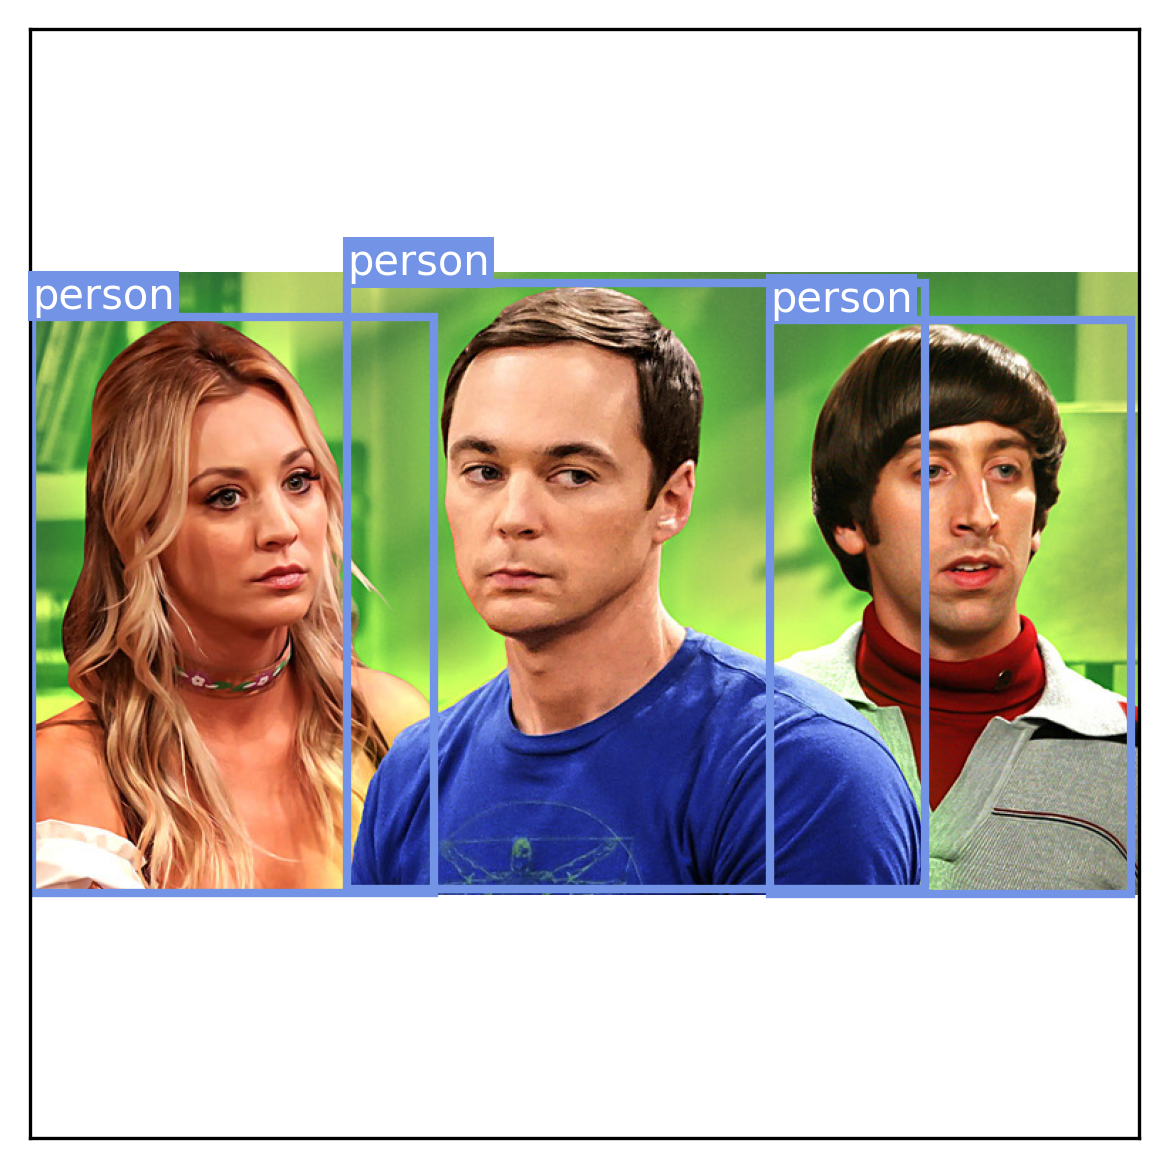

In [ ]:
# Example 3

path_3 = "image9.jpg"
image_3 = np.array([tf.keras.utils.load_img(path_3)])
predictions_3 = retinanet_detector.predict(image_3)
draw_final_image(path_3, predictions_3)